In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import cv2
import torch
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid

array([2.33333333, 1.33333333, 1.66666667, ..., 3.        , 2.66666667,
       2.33333333])

In [56]:
if 1:
    import glob
    import joblib
    import os
    from PIL import Image
    import imagehash
    from tqdm.auto import tqdm

    paths = glob.glob('../input/petfinder-adoption-prediction/*/*jpg')

    result = joblib.Parallel(n_jobs=-1, verbose=1)(joblib.delayed(lambda x: imagehash.average_hash(Image.open(x)))(path) for path in paths)


    tmp = pd.DataFrame()
    tmp['path'] = paths
    tmp['hash'] = result
    tmp['hash'] = tmp['hash'].astype(str)

    tmp['is_train'] = tmp['path'].str.find('train') > -1
    tmp['is_test'] = tmp['path'].str.find('test') > -1
    tmp['idx'] = tmp['path'].map(lambda x: int(x.split('-')[-1][:-4]))
    tmp['PetID'] = tmp['path'].map(lambda x: x.split('/')[-1].split('-')[0])
    
    df1_train = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
    df1_test = pd.read_csv('../input/petfinder-adoption-prediction/test/test.csv')
    
    aaa = [df1_test['PetID'].map(pd.read_csv(path, index_col='PetID')['AdoptionSpeed']).values
     for path in glob.glob('../input/pet-data/prev*.csv')]
    aaa = np.mean([t for t in aaa if not np.isnan(t.sum())], axis=0)

    df1_test['AdoptionSpeed'] = aaa

    df1_train = pd.merge(tmp, df1_train, how='left', on='PetID')

    df1['is_train'] = df1['is_train'].astype(np.float32)
    df1['is_test'] = df1['is_train'].astype(np.float32)
    df1['hash'] = df1['hash'].astype(str)
    df1 = df1[(df1['is_train'] > 0 ) | (~df1['hash'].isin(df1.loc[df1['is_train'] > 0, 'hash']))].reset_index(drop=True)
    df1.to_csv('df1_train_test_v4.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2624 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 4424 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 6624 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 9224 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 12224 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 15624 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 20608 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 29008 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 38208 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 50016 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 71616 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 72776 out of 72776 | elapsed:  1.1min finished


In [3]:
import os
from PIL import Image
import imagehash
from tqdm.auto import tqdm

if 0:
    df1 = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv')
    df1['path'] = '../input/petfinder-adoption-prediction/train_images/' + df1['PetID'] + '-1.jpg'
    df1 = df1[df1['path'].map(os.path.exists)]

    df2 = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
    df2['path'] = df2['Id'].map(lambda x:str(f'../input/petfinder-pawpularity-score/train/{x}.jpg'))

    df1['hash'] = [imagehash.average_hash(Image.open(x))
                        for x in tqdm(df1['path'].values)]
    df2['hash'] = [imagehash.average_hash(Image.open(x))
                        for x in tqdm(df2['path'].values)]
    #train_df_prev['hash'] = [imagehash.average_hash(Image.open(x))
    #                    for x in tqdm(train_df_prev['path'].values)]

    df1.to_csv('df1.csv', index=False)
    df2.to_csv('df2.csv', index=False)
else:
    df1 = pd.read_csv('df1_train_test.csv')
    df2 = pd.read_csv('df2.csv')

In [4]:
df1.shape, df1.hash.nunique()

((72776, 29), 70437)

In [5]:
if 0:
    import json
    def read_json(path):
        try:
            with open(path) as f:
                dict_f = json.load(f)
            return dict_f['documentSentiment']
        except FileNotFoundError:
            return {}
    aaa = ('../input/petfinder-adoption-prediction/train_sentiment/' + df1['PetID'] + '.json').map(read_json)
    tmp = pd.DataFrame(aaa.values.tolist())
    df1 = pd.concat([df1, tmp], axis=1)

In [58]:
if 1:
    from sklearn.feature_extraction.text import TfidfVectorizer
    model = TfidfVectorizer(stop_words=None,#np.load('stop_words.npy').tolist(),
                                binary=False,
                                norm=None,#'l1',
                                #analyzer='char_wb',
                                #ngram_range=(2, 5),
                                # tokenizer=tokenizer,
                                # max_features=50000,
                                #max_df=50,
                                min_df=2,
                                dtype=np.float32)

    #data = model.fit_transform(df1['Description'].fillna('').str.lower().values)
    #df1['desc_sum'] = np.array(data.sum(axis=1))[:, 0]
    #df1['desc_max'] = np.array(data.max(axis=1).todense())[:, 0]
    #df1['desc_mean'] = df1['desc_sum'] / (data.getnnz(axis=1))


    data = model.fit_transform(df1['Name'].fillna('').str.lower().values)
    print(data.shape)
    df1['name_sum'] = np.array(data.sum(axis=1))[:, 0]
    df1['name_max'] = np.array(data.max(axis=1).todense())[:, 0]
    df1['name_mean'] =  df1['name_sum'] / data.getnnz(axis=1)

(72686, 6610)


In [60]:
np.norm(data)

matrix([[63.448727],
        [30.17784 ],
        [ 9.796022],
        ...,
        [ 0.      ],
        [ 9.303546],
        [31.719341]], dtype=float32)

In [7]:
if 0:
    #vocab = ['abandoned', 'active', 'adopt', 'adopted', 'adoption', 'after', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'being', 'bring', 'but', 'by', 'call', 'can', 'care', 'cat', 'contact', 'cute', 'dog', 'family', 'for', 'forever', 'found', 'from', 'give', 'good', 'has', 'have', 'he', 'healthy', 'heavy', 'her', 'him', 'home', 'if', 'in', 'interested', 'is', 'it', 'likes', 'looking', 'loving', 'male', 'me', 'months', 'mother', 'must', 'my', 'new', 'no', 'not', 'of', 'old', 'on', 'or', 'other', 'out', 'playful', 'please', 'puppy', 'rescued', 'she', 'so', 'spayed', 'take', 'than', 'that', 'the', 'they', 'this', 'to', 'trained', 'vaccination', 'very', 'visit', 'was', 'we', 'well', 'whatsapp', 'who', 'will', 'with', 'would', 'you']
    vocab = ['active', 'adopt', 'adoption', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'bring', 'but', 'by', 'call', 'can', 'care', 'cat', 'contact', 'cute', 'dog', 'family', 'for', 'from', 'give', 'good', 'has', 'have', 'he', 'healthy', 'her', 'him', 'home', 'if', 'in', 'interested', 'is', 'it', 'looking', 'loving', 'me', 'must', 'my', 'no', 'not', 'of', 'old', 'on', 'or', 'playful', 'please', 'rescued', 'she', 'spayed', 'that', 'the', 'they', 'this', 'to', 'trained', 'very', 'was', 'we', 'whatsapp', 'will', 'with', 'you']
    #vocab = ['active', 'adopt', 'adoption', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'bring', 'but', 'by', 'can', 'care', 'cat', 'contact', 'cute', 'dog', 'family', 'for', 'give', 'good', 'has', 'have', 'he', 'healthy', 'her', 'him', 'home', 'if', 'in', 'interested', 'is', 'it', 'looking', 'loving', 'me', 'must', 'my', 'no', 'not', 'of', 'old', 'on', 'or', 'playful', 'please', 'rescued', 'she', 'spayed', 'that', 'the', 'they', 'this', 'to', 'trained', 'very', 'was', 'we', 'will', 'with', 'you']
    model = TfidfVectorizer(stop_words=None,#np.load('stop_words.npy').tolist(),
                                binary=False,
                                #norm='l1',
                                #analyzer='char_wb',
                                #ngram_range=(2, 5),
                                # tokenizer=tokenizer,
                                # max_features=50000,
                                #max_df=50,
                                #vocabulary=vocab,
                                min_df=2,
                                dtype=np.float32)

    tmp = df1['Description'].fillna('').str.lower()# + ' ' + df1['Name'].fillna('').str.lower() 
    #data = model.fit_transform(df1['Description'].fillna('').str.lower().values)
    data = model.fit_transform(tmp.values)

    map_i2w = {v:k for k, v in model.vocabulary_.items()}
    #data = np.array(data.todense())

    if 1:
        for w in vocab:
            if w in model.vocabulary_:
                df1[f'tfidf_{w}'] = np.array(data[:, model.vocabulary_[w]].todense())
    else:
        for w, i in model.vocabulary_.items():
            df1[f'tfidf_{w}'] = np.array(data[:, i].todense())

    #for w in ['white', 'boy']:
    #    df1[f'tfidf_{w}'] = np.array(data[:, model.vocabulary_[w]].todense())



In [8]:
#!pip install -U transformers

In [9]:
import transformers
transformers.__version__

'4.15.0'

In [10]:
#df2 = pd.merge(df2, pd.read_csv('breed.csv'), how='left', on='path')

In [11]:
#df1.to_csv('train_last_comp.csv', index=False)
df = pd.merge(df2, df1, how='left', on='hash')

In [12]:
df['len_desc'] = df['Description'].fillna('').map(len)
df['len_word_desc'] = df['Description'].fillna('').map(lambda x: len(x.split()))
for n in ['No Name Yet']:#, 'No Name', 'Unknown']:
    df['Name'] = df['Name'].fillna('').replace(n, '')
df['len_name'] = df['Name'].map(len)
df['len_word_name'] = df['Name'].fillna('').map(lambda x: len(x.split()))

df['cnt_RescuerID'] = df['RescuerID'].map(df1['RescuerID'].value_counts())

In [13]:
#df = pd.read_csv('../exps/exp1_swin_large_patch4_window12_384/train_cv_score.csv')
#df = pd.read_csv('ens_exp15.csv')

In [14]:
df['pred'] = df['path_x'].map(pd.read_csv('ens_exp15.csv', index_col='path')['pred'])
df['pred'] += df['path_x'].map(pd.read_csv('ens_exp9.csv', index_col='path')['pred'])
df['pred'] /= 2
df['pred']

0        0.471986
1        0.402806
2        0.440848
3        0.603114
4        0.386127
           ...   
10013    0.276084
10014    0.371682
10015    0.293679
10016    0.469386
10017    0.434194
Name: pred, Length: 10018, dtype: float64

In [15]:
if 0:
    from transformers import pipeline, AutoTokenizer
    model_name = "bert-base-multilingual-uncased"
    #tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512)
    feature_extraction = pipeline('feature-extraction', model=model_name, tokenizer=model_name, padding=True, truncation=True, device=0)
    features = feature_extraction(df['Name'].fillna('').str.lower().values.tolist())
    #features = feature_extraction(df['Description'].fillna('').str.lower().values.tolist())

    data = np.stack([np.mean(f[0], axis=0) for f in features])
    for i in range(data.shape[1]):
        df[f'bert_{i}'] = data[:, i]

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

df['fold'] = -1


N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=5, random_state=365, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(df.index, df['Pawpularity'])):
    df.loc[train_index, 'fold'] = i

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [17]:
COL_FEATURES = ['Blur', 
                #'Face', 
                #'Occlusion',
                'Eyes',
                #'Accessory',
               #'Group',
                #'Human',
                #'Near',
                #'Collage',
                #'Info',# 
                #'Action',
                
                'pred',
                
                'len_desc', 'len_name', 
                #'breed_label',# 'breed_prob',
                #'len_word_desc', 'len_word_name',
                #'isin'
                #'breed_label', 'breed_prob',
                #'img_h', 'img_w',
                #'det_label', 'det_left', 'det_top', 'det_right', 'det_bottom', 'det_prob'
               ] + df1.drop(['Name', 'RescuerID', 'Description', 'PetID', 'path', 'hash',
                             'Type', 'VideoAmt', 'Sterilized', 'MaturitySize', 'Health', 'Dewormed',# 'Breed1'
                             #'is_train', 'is_test', 'idx',
                            ], axis=1, errors='ignore').columns.tolist() + [c for c in df.columns if 'bert_' in c]

#COL_FEATURES = COL_FEATURES[:7]

In [18]:
if df['Pawpularity'].values.min() == 0:
    df['Pawpularity'] += 1

In [19]:
def rmse(preds, train_data):
    labels = train_data.get_label()
    #import pdb;pdb.set_trace()
    loss = np.sqrt(((labels - preds.clip(0.01, 1)) ** 2).mean()) * 100
    
    #loss = np.sqrt(((labels - preds.reshape(-1, 100).argmax(axis=1)) ** 2).mean())
    return 'rmse', loss, False


def train(fold, param):
     
    X_train = df.loc[df['fold'] != fold, COL_FEATURES]
    y_train = df.loc[df['fold'] != fold, 'Pawpularity'].values  / 100
    
    X_valid = df.loc[df['fold'] == fold, COL_FEATURES]
    y_valid = df.loc[df['fold'] == fold, 'Pawpularity'].values  / 100
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(param,
                      train_data,
                      valid_sets=valid_data,
                      #early_stopping_rounds=50,
                      verbose_eval=1000,
                      feval=rmse
                      )
    return model

def train_all(param):
     
    X_train = df.loc[:, COL_FEATURES]
    y_train = df.loc[:, 'Pawpularity'].values  / 100
    
    X_valid = df.loc[:, COL_FEATURES]
    y_valid = df.loc[:, 'Pawpularity'].values  / 100
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(param,
                      train_data,
                      valid_sets=valid_data,
                      early_stopping_rounds=50,
                      verbose_eval=1000,
                      feval=rmse
                      )
    return model

In [20]:
all_params = {'objective': ['tweedie'],
              'tweedie_variance_power': [1.2],
             'verbosity': [-1],
             'boosting_type': ['gbdt'],
             'feature_pre_filter': [False],
             #'bagging_fraction': [0.7, 0.8, 0.9, 1],
             'bagging_freq': [1],
             'num_iterations': [10000],
             'early_stopping_round': [100],
             'n_jobs': [16],
             'seed': [114],
             'metric':  ['None'],  # trial.suggest_categorical('metric', ['auc', 'binary_logloss', ]), #'auc',
             'learning_rate': [0.05],
              'lambda_l1': [0],
              'lambda_l2': [1],
              'min_child_samples': [170],
              'num_leaves': [7],
              'feature_fraction': [0.8],
              'min_gain_to_split': [0.02],
              'linear_tree': [False],
              #'max_bins': [8, 16, 32, 62, 128, 256, 512]
             }

In [21]:
best_score = 1.0e10
best_param = None
for param in tqdm(ParameterGrid(all_params)):
    print(param)
    list_loss = []
    list_imp = []
    list_num = []
    for fold in range(5):
        model = train(fold, param)
        sc = model.best_score['valid_0']['rmse']# * 100
        list_loss.append(sc)
        list_num.append(model.best_iteration)
        
        imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
        imp['col'] = COL_FEATURES
        list_imp.append(imp.set_index('col'))
    sc = np.mean(list_loss)
    if sc < best_score:
        best_score = sc
        best_param = param

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


{'bagging_freq': 1, 'boosting_type': 'gbdt', 'early_stopping_round': 100, 'feature_fraction': 0.8, 'feature_pre_filter': False, 'lambda_l1': 0, 'lambda_l2': 1, 'learning_rate': 0.05, 'linear_tree': False, 'metric': 'None', 'min_child_samples': 170, 'min_gain_to_split': 0.02, 'n_jobs': 16, 'num_iterations': 10000, 'num_leaves': 7, 'objective': 'tweedie', 'seed': 114, 'tweedie_variance_power': 1.2, 'verbosity': -1}
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 17.485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's rmse: 16.7592
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	valid_0's rmse: 17.0413
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's rmse: 17.4323
Training until validation scores don't improve for 100 rounds
Early stopping,

In [22]:
17.122953793907463
17.12237161917507
17.12206798235878
17.118772493988214
17.11253518980743
17.10951939364919
17.10667371043545
print(best_param)
print(best_score)

{'bagging_freq': 1, 'boosting_type': 'gbdt', 'early_stopping_round': 100, 'feature_fraction': 0.8, 'feature_pre_filter': False, 'lambda_l1': 0, 'lambda_l2': 1, 'learning_rate': 0.05, 'linear_tree': False, 'metric': 'None', 'min_child_samples': 170, 'min_gain_to_split': 0.02, 'n_jobs': 16, 'num_iterations': 10000, 'num_leaves': 7, 'objective': 'tweedie', 'seed': 114, 'tweedie_variance_power': 1.2, 'verbosity': -1}
17.147163499364762


In [23]:
best_param['num_iterations'] = round(np.mean(list_num) * 1.1)

In [24]:
model = train_all(best_param)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's rmse: 16.8588


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [25]:
aaa = 0
for i in range(5):
    aaa += np.sqrt(((df.loc[df['fold']==i, 'pred'] * 100 - df.loc[df['fold']==i, 'Pawpularity']) ** 2).mean())
aaa / 5

17.26982888789386

In [26]:
with open('models/model_lgb_last_comp_all.pkl', 'wb') as f:
    pickle.dump(model, f, -1)

<Figure size 576x432 with 0 Axes>

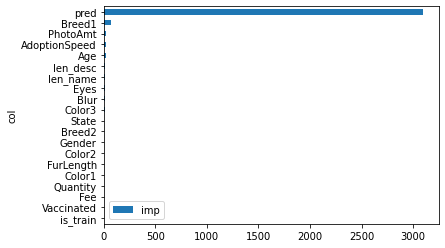

In [27]:
#imp = pd.DataFrame(model.feature_importance(importance_type='gain'), columns=['imp'])
#imp['col'] = COL_FEATURES
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
pd.options.display.max_rows = 3000
imp = sum(list_imp) / 5
#imp = imp[imp.imp > 0]
imp.sort_values('imp', ascending=True).tail(20).plot(kind='barh')
plt.show()

In [28]:
print([c[6:] for c in imp.index if 'tfidf_' in c])

[]


In [29]:
print([c for c in imp.index if 'tfidf_name_' in c])

[]


In [30]:
df.len_desc

0        102
1        601
2         88
3          0
4          0
        ... 
10013      0
10014      0
10015      0
10016    157
10017      0
Name: len_desc, Length: 10018, dtype: int64

In [31]:
model.feature_name()

['Blur',
 'Eyes',
 'pred',
 'len_desc',
 'len_name',
 'is_train',
 'is_test',
 'idx',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'FurLength',
 'Vaccinated',
 'Quantity',
 'Fee',
 'State',
 'PhotoAmt',
 'AdoptionSpeed']